## Load data

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import os

In [19]:
data = [pd.read_csv(f'/Users/tommasomarrucci/Desktop/IMC BIEF 42/data/round_4/prices_round_4_day_{i}.csv', sep=';') for i in range(1,4)]
trades = [pd.read_csv(f'/Users/tommasomarrucci/Desktop/IMC BIEF 42/data/round_4/trades_round_4_day_{i}.csv', sep=';') for i in range(1,4)]
observation = [pd.read_csv(f'/Users/tommasomarrucci/Desktop/IMC BIEF 42/data/round_4/observations_round_4_day_{i}.csv', sep=',') for i in range(1,4)]


for i in range(1,3): 
    price_df = data[i]
    prev_df = data[i-1]
    price_df['timestamp'] = price_df['timestamp'] + prev_df['timestamp'].iloc[-1]

data = pd.concat(data).reset_index(drop=True)
trades = pd.concat(trades).reset_index(drop=True)
observation = pd.concat(observation).reset_index(drop=True)

In [44]:
products = data['product'].unique()
products = np.sort(products)
products 

array(['CROISSANTS', 'DJEMBES', 'JAMS', 'KELP', 'MAGNIFICENT_MACARONS',
       'PICNIC_BASKET1', 'PICNIC_BASKET2', 'RAINFOREST_RESIN',
       'SQUID_INK', 'VOLCANIC_ROCK', 'VOLCANIC_ROCK_VOUCHER_10000',
       'VOLCANIC_ROCK_VOUCHER_10250', 'VOLCANIC_ROCK_VOUCHER_10500',
       'VOLCANIC_ROCK_VOUCHER_9500', 'VOLCANIC_ROCK_VOUCHER_9750'],
      dtype=object)

In [45]:
# import plotly.express as px

# fig = px.line(data, x='timestamp', y='mid_price', color='product', title='Mid Prices Over Time')
# # fig.show()

In [46]:
def plot_mid_price(data, product):
    """
    Plot mid price over time for a single product.
    
    Parameters:
        data (pd.DataFrame): DataFrame containing columns ['timestamp', 'product', 'mid_price'].
        product (str): Name of the product to plot.
    """
    product_data = data[data['product'] == product]

    if product_data.empty:
        print(f"No data found for product: {product}")
        return

    plt.figure(figsize=(12, 4))
    plt.plot(product_data['timestamp'], product_data['mid_price'], label=product)
    plt.title(f'{product} Mid Price Over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Mid Price')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [47]:
for product in data['product'].unique():
    globals()[product] = data[data['product'] == product].copy()

In [66]:
def compute_correlation_matrix(df, products, rolling_window=None, plot=True):
    """
    Computes (rolling) correlation matrix for mid prices of given products from a DataFrame.

    Args:
        df (pd.DataFrame): Full dataframe containing all products and price data.
        products (list): List of product names as strings (e.g. ['BANANAS', 'CROISSANTS']).
        rolling_window (int or None): Window size for rolling correlation. If None, uses full data.
        plot (bool): Whether to show a heatmap plot.

    Returns:
        pd.DataFrame: Correlation matrix.
    """
    # Build mid_price columns and align by timestamp
    mid_prices = pd.DataFrame()

    for product in products:
        product_df = df[df['product'] == product][['timestamp', 'ask_price_1', 'bid_price_1']].copy()
        product_df['mid_price'] = (product_df['ask_price_1'] + product_df['bid_price_1']) / 2
        product_df = product_df[['timestamp', 'mid_price']].rename(columns={'mid_price': product})

        if mid_prices.empty:
            mid_prices = product_df
        else:
            mid_prices = pd.merge(mid_prices, product_df, on='timestamp', how='outer')

    # Sort by timestamp and forward fill missing values
    mid_prices = mid_prices.sort_values('timestamp').ffill()

    # Drop timestamp column
    price_data = mid_prices.drop(columns='timestamp')

    # Rolling or full correlation
    if rolling_window:
        correlation_matrix = price_data.rolling(rolling_window).corr().dropna()
    else:
        correlation_matrix = price_data.corr()

    # Plot if requested
    if plot and rolling_window is None:
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title("Correlation Matrix of Mid Prices")
        plt.show()

    return correlation_matrix

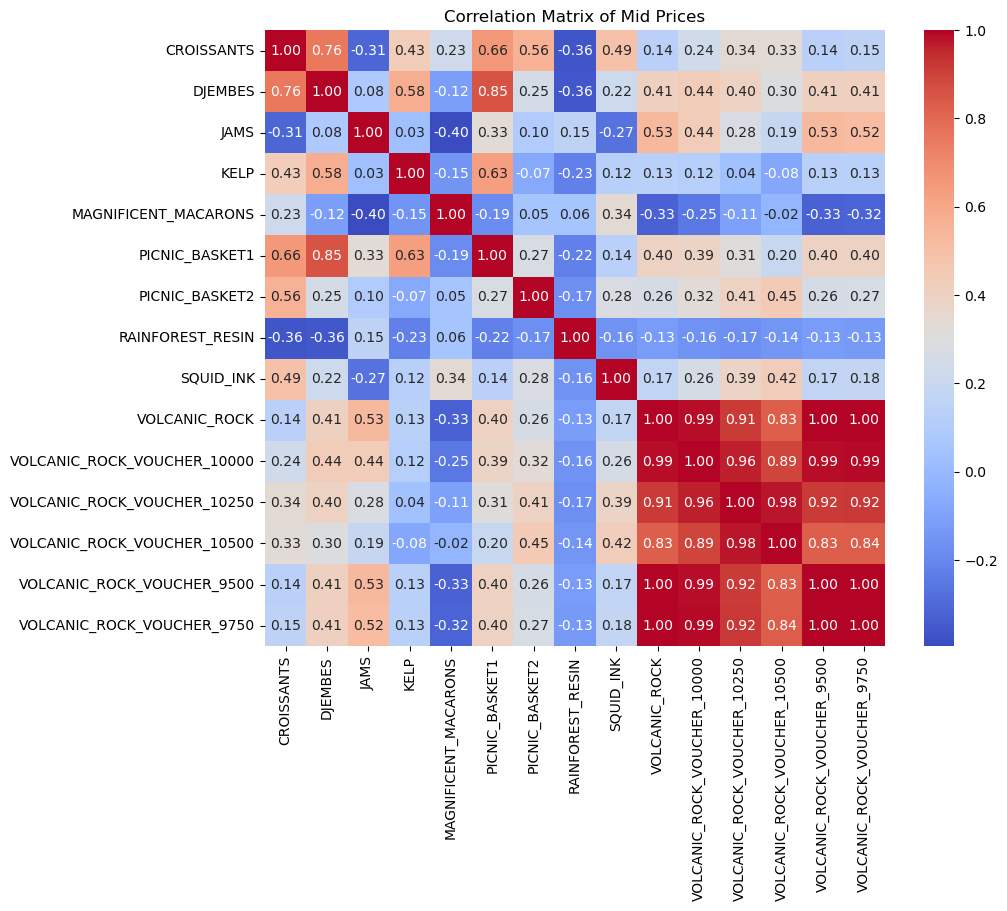

,CROISSANTS,DJEMBES,JAMS,KELP,MAGNIFICENT_MACARONS,PICNIC_BASKET1,PICNIC_BASKET2,RAINFOREST_RESIN,SQUID_INK,VOLCANIC_ROCK,VOLCANIC_ROCK_VOUCHER_10000,VOLCANIC_ROCK_VOUCHER_10250,VOLCANIC_ROCK_VOUCHER_10500,VOLCANIC_ROCK_VOUCHER_9500,VOLCANIC_ROCK_VOUCHER_9750
CROISSANTS,1.000000,0.757069,-0.308920,0.432101,0.227462,0.655004,0.561736,-0.364332,0.488440,0.137607,0.236564,0.336576,0.330282,0.138555,0.150456
DJEMBES,0.757069,1.000000,0.082320,0.577055,-0.116464,0.854919,0.250320,-0.359323,0.221533,0.408201,0.436779,0.398381,0.295727,0.408526,0.413238
JAMS,-0.308920,0.082320,1.000000,0.026148,-0.395358,0.334558,0.100448,0.149984,-0.274421,0.527423,0.435210,0.278866,0.192092,0.526606,0.517073
KELP,0.432101,0.577055,0.026148,1.000000,-0.152346,0.632065,-0.072935,-0.225422,0.123092,0.129033,0.117376,0.035930,-0.081497,0.129043,0.128775
MAGNIFICENT_MACARONS,0.227462,-0.116464,-0.395358,-0.152346,1.000000,-0.185596,0.053975,0.056566,0.337317,-0.326685,-0.252398,-0.107831,-0.017009,-0.326101,-0.318562
PICNIC_BASKET1,0.655004,0.854919,0.334558,0.632065,-0.185596,1.000000,0.274699,-0.222198,0.137368,0.396089,0.388882,0.309407,0.198297,0.396085,0.396758
PICNIC_BASKET2,0.561736,0.250320,0.100448,-0.072935,0.053975,0.274699,1.000000,-0.174480,0.277073,0.259319,0.324557,0.405708,0.446522,0.259921,0.267736
RAINFOREST_RESIN,-0.364332,-0.359323,0.149984,-0.225422,0.056566,-0.222198,-0.174480,1.000000,-0.156862,-0.125665,-0.159076,-0.173136,-0.144855,-0.126015,-0.130236
SQUID_INK,0.488440,0.221533,-0.274421,0.123092,0.337317,0.137368,0.277073,-0.156862,1.000000,0.167521,0.260130,0.386615,0.424985,0.168400,0.178919
VOLCANIC_ROCK,0.137607,0.408201,0.527423,0.129033,-0.326685,0.396089,0.259319,-0.125665,0.167521,1.000000,0.987146,0.914661,0.827183,0.999939,0.999715


In [67]:
compute_correlation_matrix(data, products)  

In [65]:
# Load the out-of-sample file
out_of_sample = pd.read_csv('/Users/tommasomarrucci/Desktop/IMC BIEF 42/Out_of_Sample.csv', sep=';')

# Adjust timestamp in the new data to follow from the last timestamp in existing data
out_of_sample['timestamp'] += data['timestamp'].iloc[-1]

# Concatenate and reset index
newdata = pd.concat([data, out_of_sample]).reset_index(drop=True)

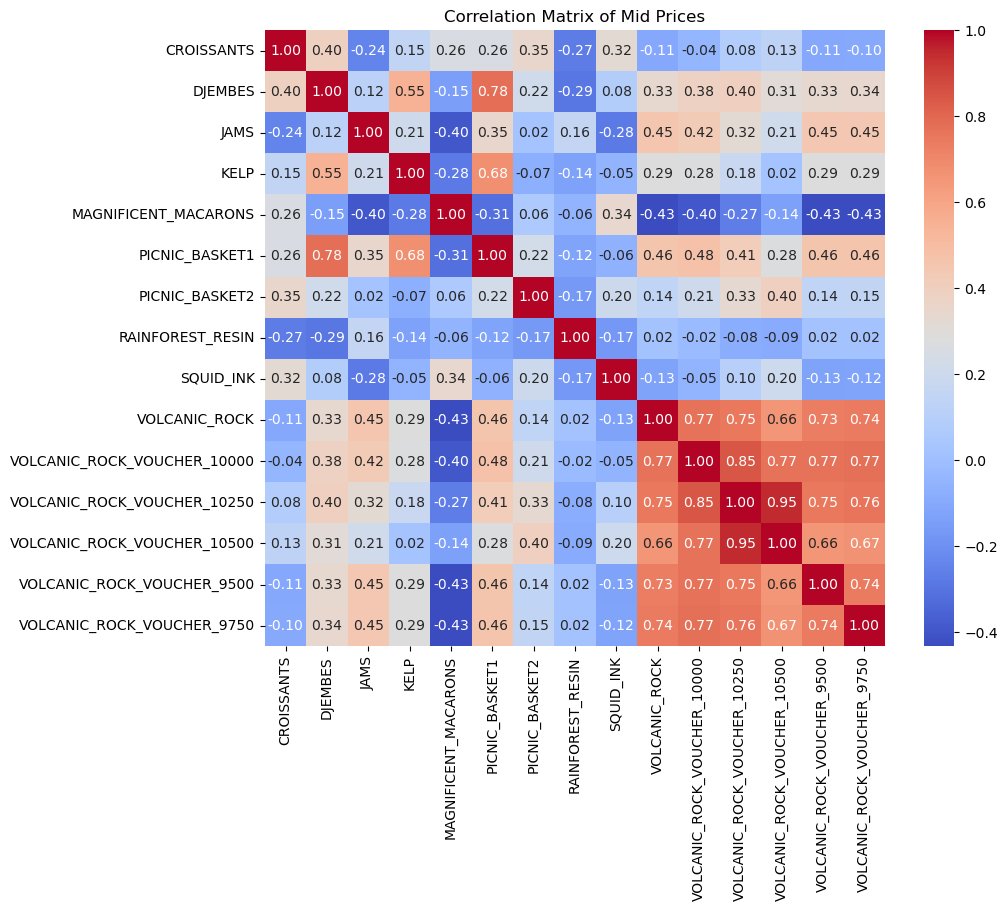

,CROISSANTS,DJEMBES,JAMS,KELP,MAGNIFICENT_MACARONS,PICNIC_BASKET1,PICNIC_BASKET2,RAINFOREST_RESIN,SQUID_INK,VOLCANIC_ROCK,VOLCANIC_ROCK_VOUCHER_10000,VOLCANIC_ROCK_VOUCHER_10250,VOLCANIC_ROCK_VOUCHER_10500,VOLCANIC_ROCK_VOUCHER_9500,VOLCANIC_ROCK_VOUCHER_9750
CROISSANTS,1.000000,0.395389,-0.243246,0.145858,0.256012,0.258485,0.347626,-0.271279,0.322396,-0.108009,-0.042277,0.078271,0.131041,-0.107419,-0.101139
DJEMBES,0.395389,1.000000,0.119748,0.551597,-0.145532,0.779112,0.215800,-0.290702,0.084325,0.334552,0.384259,0.395999,0.305922,0.334850,0.340627
JAMS,-0.243246,0.119748,1.000000,0.210368,-0.399124,0.348839,0.020625,0.157358,-0.280189,0.451604,0.423623,0.320085,0.213405,0.451199,0.449368
KELP,0.145858,0.551597,0.210368,1.000000,-0.280430,0.677506,-0.072656,-0.136060,-0.054268,0.286234,0.276624,0.177785,0.021516,0.286107,0.286309
MAGNIFICENT_MACARONS,0.256012,-0.145532,-0.399124,-0.280430,1.000000,-0.312170,0.056107,-0.056015,0.344180,-0.432977,-0.397023,-0.267303,-0.139270,-0.432546,-0.430022
PICNIC_BASKET1,0.258485,0.779112,0.348839,0.677506,-0.312170,1.000000,0.223631,-0.119810,-0.061708,0.460714,0.475698,0.414183,0.276978,0.460679,0.463414
PICNIC_BASKET2,0.347626,0.215800,0.020625,-0.072656,0.056107,0.223631,1.000000,-0.165845,0.198422,0.138524,0.209044,0.332327,0.400895,0.139035,0.146058
RAINFOREST_RESIN,-0.271279,-0.290702,0.157358,-0.136060,-0.056015,-0.119810,-0.165845,1.000000,-0.172267,0.019809,-0.021991,-0.082221,-0.092734,0.019439,0.015401
SQUID_INK,0.322396,0.084325,-0.280189,-0.054268,0.344180,-0.061708,0.198422,-0.172267,1.000000,-0.127872,-0.054870,0.103794,0.201825,-0.127220,-0.120644
VOLCANIC_ROCK,-0.108009,0.334552,0.451604,0.286234,-0.432977,0.460714,0.138524,0.019809,-0.127872,1.000000,0.767145,0.751204,0.655170,0.733025,0.737294


In [68]:
compute_correlation_matrix(newdata, products)

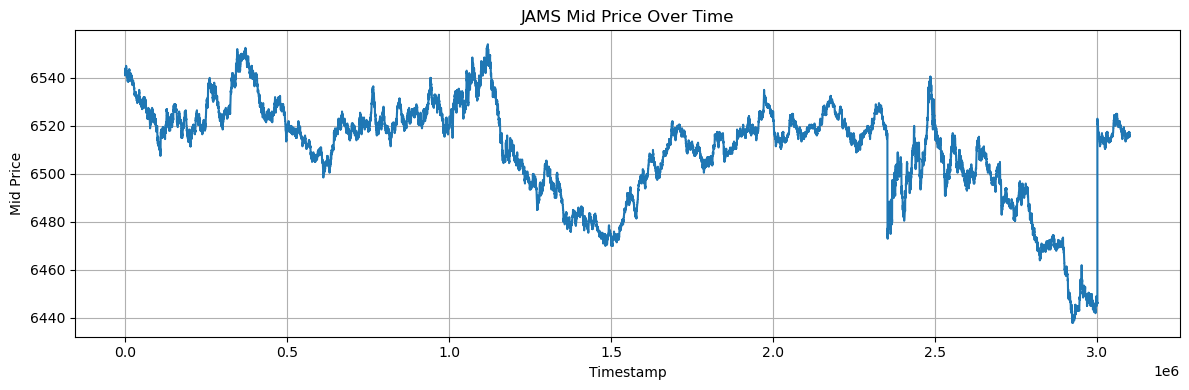

In [72]:
plot_mid_price(newdata, "JAMS")